In [64]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from netCDF4 import Dataset
import datetime
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import cmocean
import pandas as pd
from scipy import interpolate
import glob

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

0
0


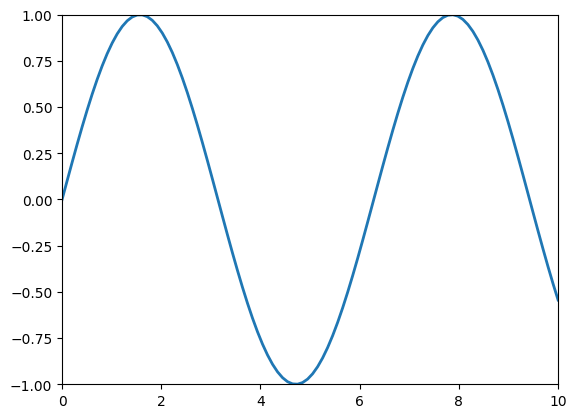

In [46]:
## EXAMPLE creation of animation

# Create the figure and axes
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

# Function to update the plot for each frame
def update(frame):
    print(frame)
    x = np.linspace(0, 10, 100)
    y = np.sin(x + frame * 0.1)
    line.set_data(x, y)
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=100, blit=True)

# Save the animation as a GIF
# ani.save('my_animation.gif', writer='pillow', fps=30)

In [78]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
# fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
fn = 'firnprofile_maxheight_solar-correction_created_20250603.nc'
uncorrect_fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data_solar = {}
if fn==uncorrect_fn:
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn==uncorrect_fn:
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data_solar['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature' and fn!=uncorrect_fn:
        season_data_solar['temperature'] = fdic['temp']
    else:
        season_data_solar[var] = fdic[var]

if fn==uncorrect_fn:
    season_data_solar['height'] = season_data_solar['initial_height'][::-1]
    season_data_solar['temperature'] = season_data_solar['temperature'][:,::-1]
else:
    season_data_solar['height'] = season_data_solar['initial_height']

In [79]:
simba_dates = season_data_solar['dates']
simba_temps = season_data_solar['temperature']
simba_depths = season_data_solar['height']

In [80]:
print(simba_dates[-1])

2024-07-23 23:45:00


In [81]:
## remove intial timesteps that don't have data
date_idx = np.where(simba_dates>datetime.datetime(2024,5,20,15))
simba_dates = simba_dates[date_idx]
simba_temps = simba_temps[date_idx[0],:]

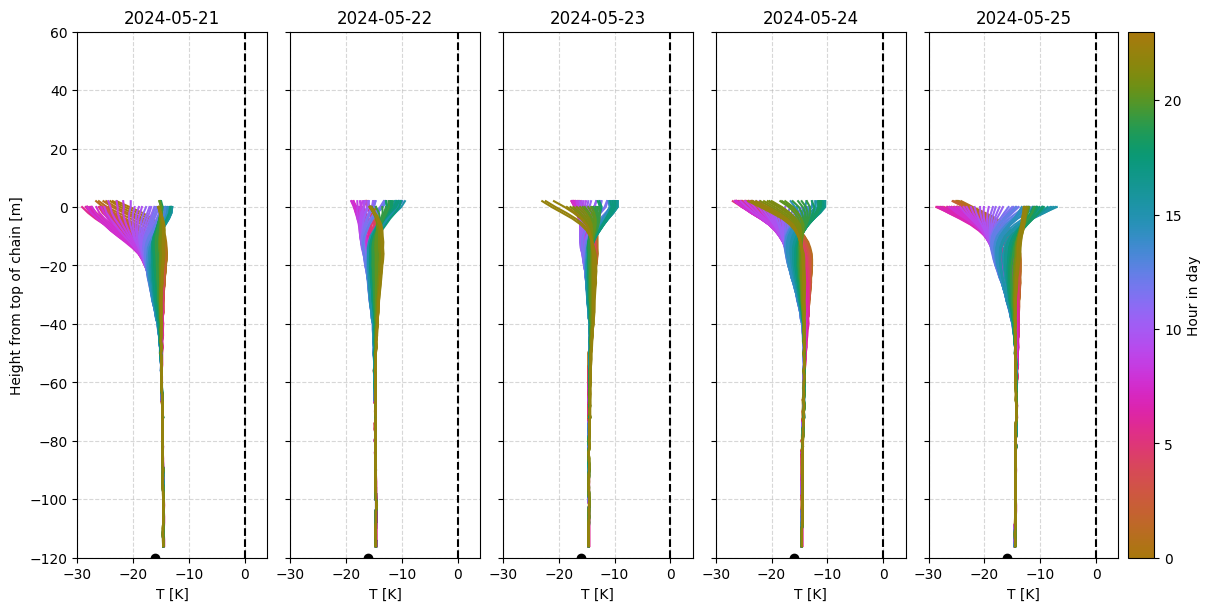

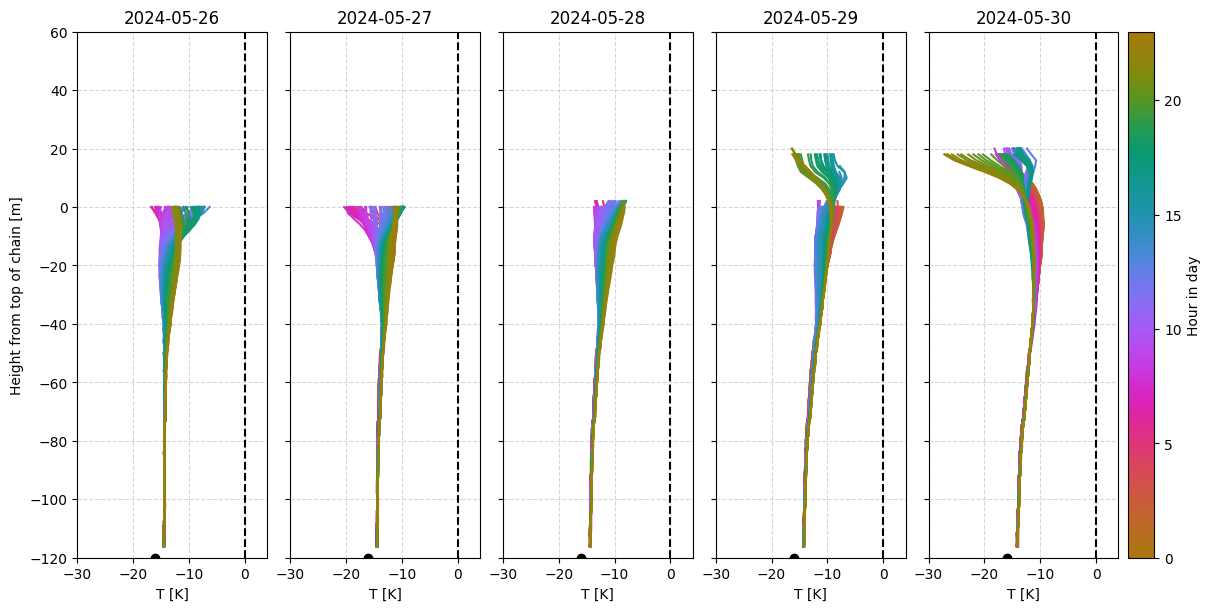

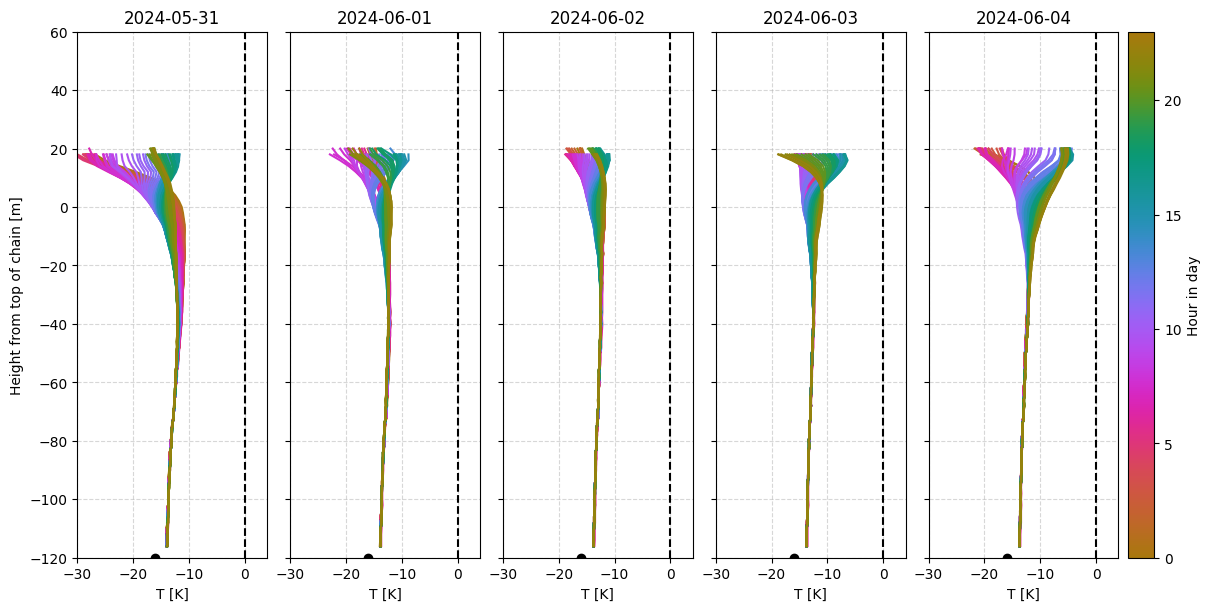

In [33]:
# Look at profiles?
cmap = cmocean.cm.phase

## for may
for day in range(20,31,5):

## for july
# for day in range(1,26,5):
    fig, axs = plt.subplots(1,5, figsize=(12,6), sharey=True, sharex=True, constrained_layout=True)
    axs[0].set_ylabel('Height from top of chain [m]')
    
    # day = 9
    for ad, ax in zip(range(5), axs.ravel()):
        st_date = datetime.datetime(2024,5,1)+datetime.timedelta(days=day+ad)
        en_date = st_date+datetime.timedelta(days=1)
        figure_date_idx = np.where((np.asarray(simba_dates)>=st_date )&(np.asarray(simba_dates)<en_date ))[0]

        cbar_ticks = [0, 12, 23]
        
        for i, t_idx in np.ndenumerate(figure_date_idx[1:]):#[::-1]):
            
            col = cmap(simba_dates[t_idx].hour/24.)
            # print(corrected_temps[t_idx, :])
            ax.plot(np.squeeze(simba_temps[t_idx, :-1]), simba_depths[:-1], label=t_idx, c=col)#'t=0')
    
        ax.set_xlabel('T [K]')
        ax.grid(alpha=.5, ls='--')
        ax.set_title(st_date.strftime('%Y-%m-%d'))
        ax.axvline(x=0., c='k', ls='--')
        ax.set_xlim(-30, 4)
        ax.scatter(-16, -120, c='k')
    axs[0].set_ylim(-120,60)
    cmappable = ScalarMappable(norm=Normalize(0,23), cmap=cmap)
    
    #colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
    cbar = plt.colorbar(cmappable, label='Hour in day', ax=axs[-1])# ticks=np.arange(0, 23))#
    # cbar.ax.set_yticklabels(cbar_ticks)
    
    # axs[-1].set_xlim(-.1,2)
    # axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
    # daystring_st = datetime.datetime(2024,5,day)
    # daystring_en = datetime.datetime(2024,5,day+4)
    # filename = 'Raven_temp-height_reverse_temp-corrected_'+daystring_st.strftime('%Y%m%d-')+daystring_en.strftime('%Y%m%d')+'.png'
    # plt.savefig('/home/asledd/ICECAPS/temperature_profiles/'+filename, dpi=250)
    plt.show()

KeyboardInterrupt: 

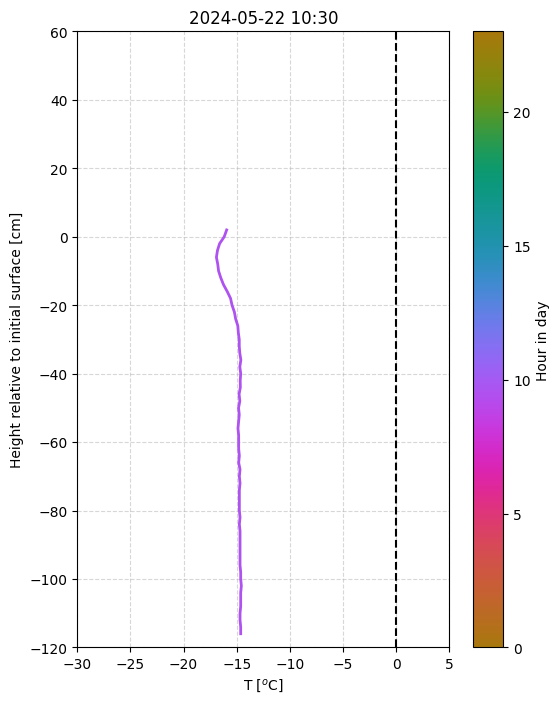

In [82]:
# try with just may time steps?

fig, ax = plt.subplots(figsize=(6,8))
line, = ax.plot([], [], lw=2)
ax.set_xlim(-30,5)
ax.set_ylim(-120, 60)
ax.set_xlabel('T [$^o$C]')
ax.grid(alpha=.5, ls='--')
ax.set_ylabel('Height relative to initial surface [cm]')
ax.axvline(x=0,c='k',ls='--',lw=1.5)
cmappable = ScalarMappable(norm=Normalize(0,23), cmap=cmap)
#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, label='Hour in day', ax=ax)


# Function to update the plot for each frame
def update(frame):
    col = cmap(simba_dates[frame].hour/24.)
    
    x = np.squeeze(simba_temps[frame, :-1])
    y = simba_depths[:-1]

    ax.set_title(simba_dates[frame].strftime('%Y-%m-%d %H:%M'))
    line.set_data(x,y)
    line.set_color(col)
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=simba_dates.shape[0], blit=True)
ani.save('SIMBA_profile_constant-ki_20240518-20240724.gif', writer='pillow', fps=25)

Add in skin temperature for another reference

In [59]:
## SIMBA surface from SIMBA_surface_detection_v2_split_vertical.ipynb
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')

simba_sfc_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_in = df['max_index'].values

In [62]:
## interpolate simba_sfc to have same timesteps as rest of simba data
sfc_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_sfc_dates])
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_dates])

f_sfc = interpolate.interp1d(sfc_seconds, simba_sfc_in, fill_value=-999, bounds_error=False)
simba_sfc = f_sfc(simba_seconds)
simba_sfc = np.ma.masked_equal(simba_sfc, -999)

In [65]:
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')

# asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/full_period/'
# asfs_lev2_files = glob.glob(asfs_filepath+'sleighsfsseb.sleighsfs.level2.0.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','snow_gpr_dist','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = dt.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )
asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp'] = np.ma.MaskedArray(**npz)

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [72]:
## interpolate simba_sfc to have same timesteps as rest of simba data
skin_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])
# simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_dates])

f_skin = interpolate.interp1d(skin_seconds, asfs_data_lev2['skin_temp'], fill_value=-999, bounds_error=False)
simba_skin = f_skin(simba_seconds)
simba_skin = np.ma.masked_equal(simba_skin, -999)

In [67]:
print(simba_skin.shape, simba_temps.shape)

(6275,) (6275, 160)


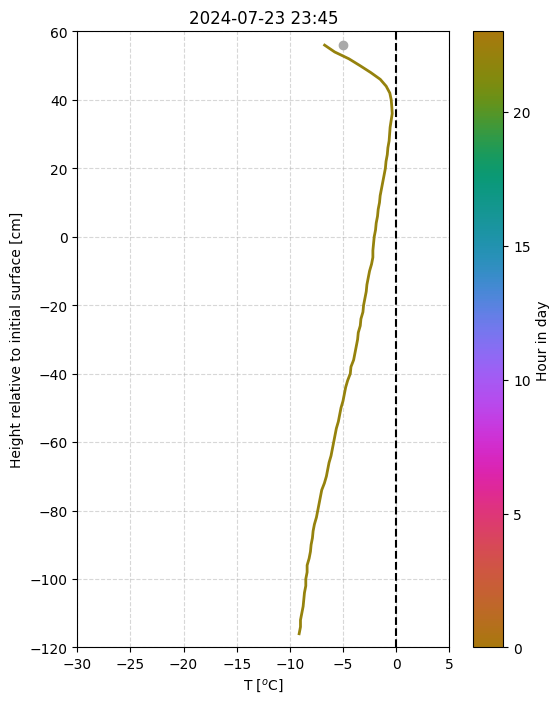

In [83]:
# try with just may time steps?

fig, ax = plt.subplots(figsize=(6,8))
line, = ax.plot([], [], lw=2)
dot, = ax.plot([], [])

ax.set_xlim(-30,5)
ax.set_ylim(-120, 60)
ax.set_xlabel('T [$^o$C]')
ax.grid(alpha=.5, ls='--')
ax.set_ylabel('Height relative to initial surface [cm]')
ax.axvline(x=0,c='k',ls='--',lw=1.5)
cmappable = ScalarMappable(norm=Normalize(0,23), cmap=cmap)
#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, label='Hour in day', ax=ax)


# Function to update the plot for each frame
def update(frame):
    col = cmap(simba_dates[frame].hour/24.)
    
    x = np.squeeze(simba_temps[frame, :-1])
    y = simba_depths[:-1]

    ax.set_title(simba_dates[frame].strftime('%Y-%m-%d %H:%M'))
    line.set_data(x,y)
    line.set_color(col)
    # print(simba_skin[frame])
    dot.set_data([simba_skin[frame]-273.15], [simba_sfc[frame]])
    dot.set_color('darkgrey')
    dot.set_marker('o')
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=simba_dates.shape[0], blit=True) 
# ani.save('SIMBA_profile_skinT_constant-ki_20240518-20240724.gif', writer='pillow', fps=25)

Try coloring profies by GPR melt index

In [84]:
df = pd.read_csv('/psd3data/arctic/sledd/Melt_Index_despiked_GPR_Raven2024.csv')

gpr_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['date'].values])       
gpr_melt = df['Melt_Index_Normal'].values

In [85]:
gpr_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in gpr_dates])

f_gpr = interpolate.interp1d(gpr_seconds, gpr_melt, 
                             fill_value=-999, bounds_error=False)

gpr_melt_interped = f_gpr(simba_seconds)
gpr_melt_interped = np.ma.masked_equal(gpr_melt_interped, -999)

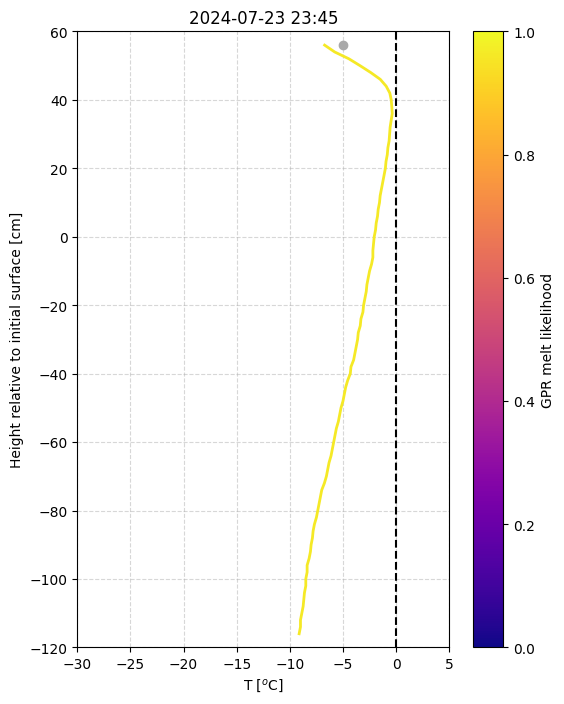

In [96]:
# try with just may time steps?

fig, ax = plt.subplots(figsize=(6,8))
line, = ax.plot([], [], lw=2)
dot, = ax.plot([], [])

ax.set_xlim(-30,5)
ax.set_ylim(-120, 60)
ax.set_xlabel('T [$^o$C]')
ax.grid(alpha=.5, ls='--')
ax.set_ylabel('Height relative to initial surface [cm]')
ax.axvline(x=0,c='k',ls='--',lw=1.5)

cmap = plt.cm.plasma
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)
#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, label='GPR melt likelihood', ax=ax)


# Function to update the plot for each frame
def update(frame):
    if np.ma.is_masked(gpr_melt_interped[frame]):
        col='k'
    else:
        col = cmap(gpr_melt_interped[frame])

    x = np.squeeze(simba_temps[frame, :-1])
    y = simba_depths[:-1]

    ax.set_title(simba_dates[frame].strftime('%Y-%m-%d %H:%M'))
    line.set_data(x,y)
    line.set_color(col)
    # print(simba_skin[frame])
    dot.set_data([simba_skin[frame]-273.15], [simba_sfc[frame]])
    dot.set_color('darkgrey')
    dot.set_marker('o')
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=simba_dates.shape[0], blit=True) 
ani.save('SIMBA_profile_skinT_constant-ki_GPR-colors_20240518-20240724.gif', writer='pillow', fps=25)

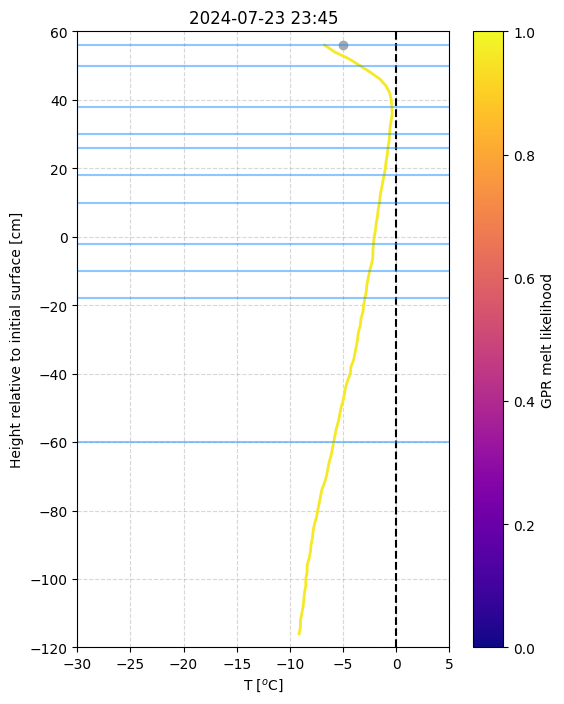

In [100]:
# try with just may time steps?

fig, ax = plt.subplots(figsize=(6,8))
line, = ax.plot([], [], lw=2)
dot, = ax.plot([], [])

ax.set_xlim(-30,5)
ax.set_ylim(-120, 60)
ax.set_xlabel('T [$^o$C]')
ax.grid(alpha=.5, ls='--')
ax.set_ylabel('Height relative to initial surface [cm]')
ax.axvline(x=0,c='k',ls='--',lw=1.5)

## highlight ice layers from demob
ice_levels = [209, 188, 184, 180, 174, 170, 166, 164, 160, 154, 151]
for lev in ice_levels:
    ax.axhline(y=lev*-2+358, c='dodgerblue', alpha=.5)

## to go from thermistor to new depth: multiply by -2 and add 358

cmap = plt.cm.plasma
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)
#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, label='GPR melt likelihood', ax=ax)


# Function to update the plot for each frame
def update(frame):
    if np.ma.is_masked(gpr_melt_interped[frame]):
        col='k'
    else:
        col = cmap(gpr_melt_interped[frame])

    x = np.squeeze(simba_temps[frame, :-1])
    y = simba_depths[:-1]

    ax.set_title(simba_dates[frame].strftime('%Y-%m-%d %H:%M'))
    line.set_data(x,y)
    line.set_color(col)
    # print(simba_skin[frame])
    dot.set_data([simba_skin[frame]-273.15], [simba_sfc[frame]])
    dot.set_color('darkgrey')
    dot.set_marker('o')
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=simba_dates.shape[0], blit=True) 
# ani = animation.FuncAnimation(fig, update, frames=100, blit=True) 

ani.save('SIMBA_profile_skinT_constant-ki_GPR-colors_final-ice_20240518-20240724_slow.gif', writer='pillow', fps=10)